In [5]:
# Graph Neural Networks detection & localization, using only voltage mag & ang
from utils import *

def load_day_data(pkl_path, attacked_nodes, attack_window):
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)

    v_sch, t_sch = data['sch_v'], data['sch_θ']
    v_att, t_att = data.get('attack_v', {}), data.get('attack_θ', {})

    steps = [f"x{i}" for i in range(attack_window[0], attack_window[1] + 1) if f"x{i}" in v_sch]
    first_val = v_sch[steps[0]]

    if isinstance(first_val, dict):
        node_keys = sorted(first_val.keys(), key=lambda x: int(x[1:]) if x[1:].isdigit() else 0)
        n_nodes = len(node_keys)

        V_sch = np.array([[v_sch[s][k] for k in node_keys] for s in steps]).T
        T_sch = np.array([[t_sch[s][k] for k in node_keys] for s in steps]).T
        V_att = np.array([[v_att.get(s, v_sch[s])[k] if isinstance(v_att.get(s, v_sch[s]), dict)
                           else V_sch[i, j] for i, k in enumerate(node_keys)] for j, s in enumerate(steps)]).T
        T_att = np.array([[t_att.get(s, t_sch[s])[k] if isinstance(t_att.get(s, t_sch[s]), dict)
                           else T_sch[i, j] for i, k in enumerate(node_keys)] for j, s in enumerate(steps)]).T
    else:
        n_nodes = len(first_val)
        V_sch = np.array([v_sch[s] for s in steps]).T
        T_sch = np.array([t_sch[s] for s in steps]).T
        V_att = np.array([v_att.get(s, v_sch[s]) for s in steps]).T
        T_att = np.array([t_att.get(s, t_sch[s]) for s in steps]).T

    # features: differences + stats
    dV, dT = V_att - V_sch, T_att - T_sch
    X = np.concatenate([
        dV.reshape(n_nodes, -1), dT.reshape(n_nodes, -1),
        V_sch.mean(axis=1, keepdims=True), V_sch.std(axis=1, keepdims=True),
        T_sch.mean(axis=1, keepdims=True), T_sch.std(axis=1, keepdims=True),
        np.abs(dV).max(axis=1, keepdims=True), np.abs(dT).max(axis=1, keepdims=True)
    ], axis=1)

    y = np.zeros(n_nodes, dtype=np.float32)
    for node_id in attacked_nodes:
        if node_id < n_nodes:
            y[node_id] = 1.0

    return X, y

print(f"FDIA detection | only voltage available\n")
adj = load_adj_matrix('topology.csv', N_NODES)
print(f"Grid topology: {N_NODES}-bus, {int(np.sum(adj)) // 2}-edge\n")  # edges includes transformers & switches
X, y, d = load_all_days(DATA, ATTACKED_NODES, ATTACK_WINDOW, load_day_data)
print(f"total data: {X.shape}, attack ratio={y.mean():.3f}\n")

In [7]:
# normalize & split
X = (X - X.mean((0, 1), keepdims=True)) / (X.std((0, 1), keepdims=True) + 1e-8)
split = int(len(X) * 0.75) ## 3 seasons as train, 1 as test, adjust as needed
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# balance class weights (mitigate 3:184 imbalance), adjust ratio according to scenarios
pos_weight = (y_train.size - y_train.sum()) / (y_train.sum() + 1e-8) * 0.5
print(f"split: train={X_train.shape[0]}, test={X_test.shape[0]} | pos_weight={pos_weight:.1f}\n")

# build & train
model = gcn(N_NODES, X.shape[2], adj)
model.compile(
    optimizer=keras.optimizers.Adam(4e-4), loss=WeightedBCE(pos_weight=pos_weight),
    metrics=[
        keras.metrics.BinaryAccuracy(name='acc', threshold=0.5),
        keras.metrics.Precision(name='prec', thresholds=0.5),
        keras.metrics.Recall(name='rec', thresholds=0.5),
        keras.metrics.AUC(name='auc')
    ]
)

hist = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=400, batch_size=32, verbose=1,
    callbacks=[ # early stopping upon perfect AUC
        keras.callbacks.EarlyStopping(monitor='val_auc', patience=20, restore_best_weights=True, mode='max'),
        keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=10, min_lr=1e-6, mode='max')
    ]
)

# eval
y_pred = model.predict(X_test, verbose=0)[:, :, 0]

split: train=606, test=203 | pos_weight=30.7

Epoch 1/400
19/19 [==============================] - 1s 20ms/step - loss: 0.7181 - acc: 0.8011 - prec: 0.0633 - rec: 0.8256 - auc: 0.8688 - val_loss: 0.9110 - val_acc: 0.8282 - val_prec: 0.0608 - val_rec: 0.6716 - val_auc: 0.8646 - lr: 4.0000e-04
Epoch 2/400
19/19 [==============================] - 0s 10ms/step - loss: 0.5125 - acc: 0.8567 - prec: 0.0994 - rec: 0.9846 - auc: 0.9523 - val_loss: 0.9012 - val_acc: 0.9163 - val_prec: 0.0703 - val_rec: 0.3448 - val_auc: 0.8886 - lr: 4.0000e-04
Epoch 3/400
19/19 [==============================] - 0s 10ms/step - loss: 0.4324 - acc: 0.8852 - prec: 0.1210 - rec: 0.9829 - auc: 0.9596 - val_loss: 0.8795 - val_acc: 0.9083 - val_prec: 0.1265 - val_rec: 0.7980 - val_auc: 0.9475 - lr: 4.0000e-04
Epoch 4/400
19/19 [==============================] - 0s 9ms/step - loss: 0.3850 - acc: 0.8971 - prec: 0.1331 - rec: 0.9818 - auc: 0.9634 - val_loss: 0.8703 - val_acc: 0.9211 - val_prec: 0.1404 - val_rec: 0.7652 - 


Top 10 suspicious nodes:
  163: 0.991 [ATTACK]
  33: 0.985 [ATTACK]
  34: 0.966 [ATTACK]
  112: 0.696 
  31: 0.532 
  29: 0.404 
  32: 0.382 
  1: 0.301 
  30: 0.199 
  135: 0.179 

classification report:
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00     37352
    attacked       0.94      0.95      0.95       609

    accuracy                           1.00     37961
   macro avg       0.97      0.97      0.97     37961
weighted avg       1.00      1.00      1.00     37961



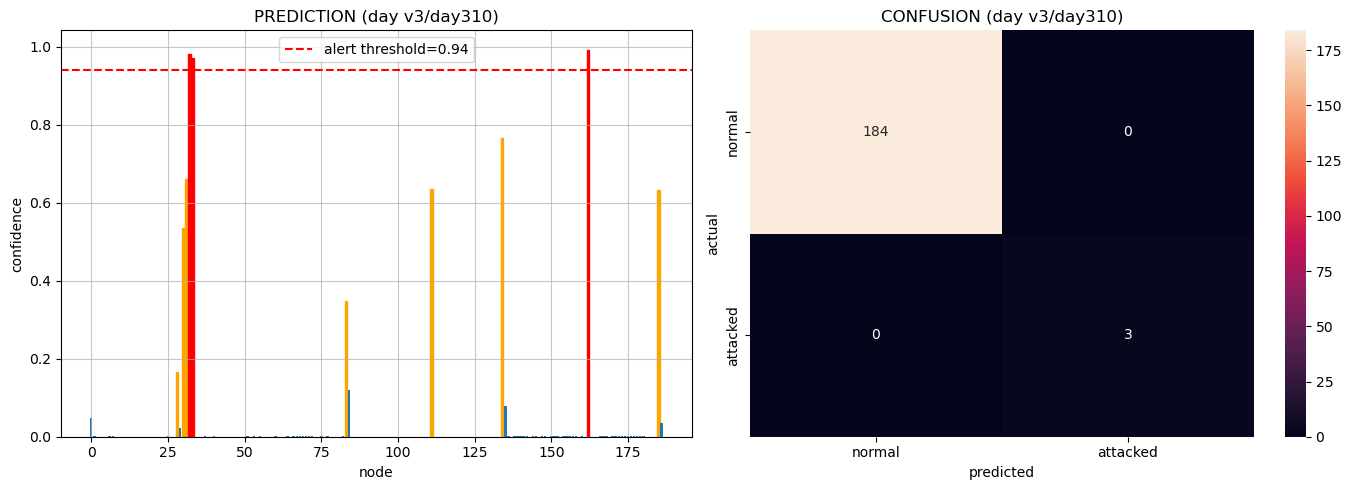

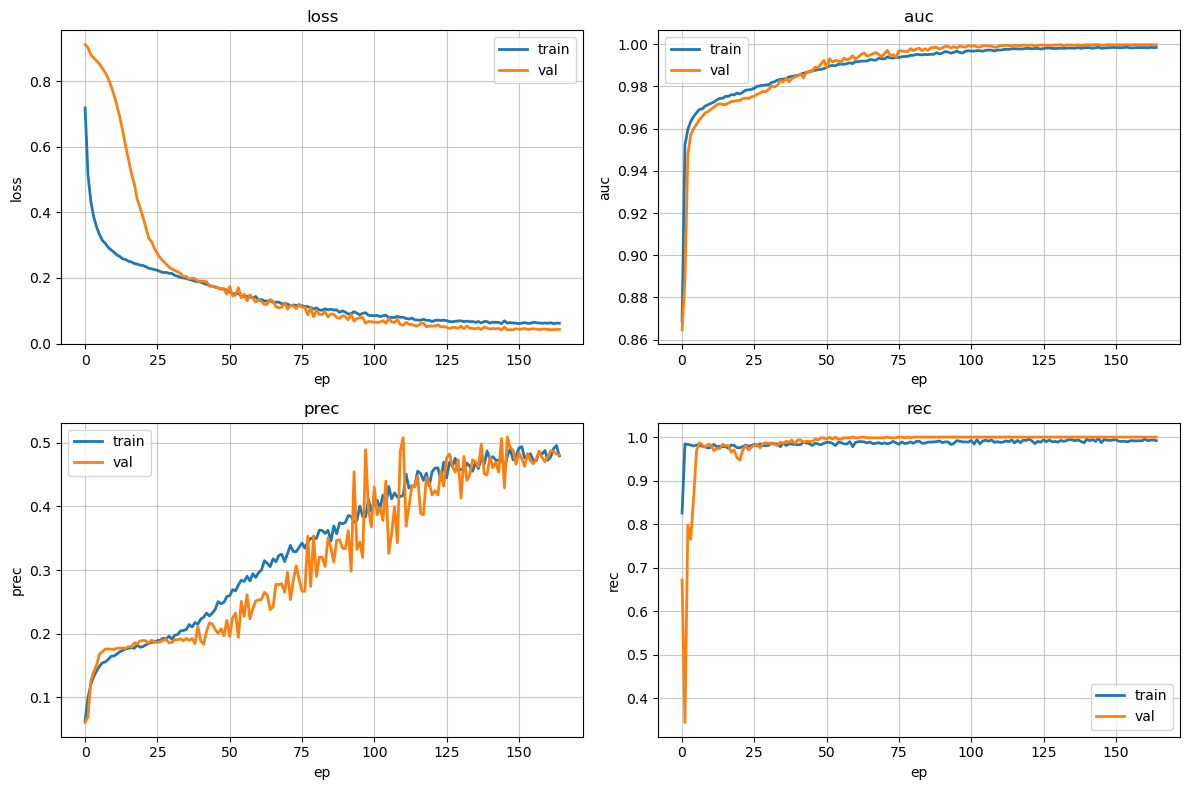

In [8]:
thresh = np.linspace(0.5, 1.0, 100)    # find optimal threshold via f1 score
f1 = []
for t in thresh:
    y_bin = (y_pred > t).astype(int)
    tp = ((y_bin == 1) & (y_test == 1)).sum()
    fp = ((y_bin == 1) & (y_test == 0)).sum()
    fn = ((y_bin == 0) & (y_test == 1)).sum()
    p = tp / (tp + fp + 1e-8)
    r = tp / (tp + fn + 1e-8)
    f1.append(2 * p * r / (p + r + 1e-8))

thresh_opt = thresh[np.argmax(f1)]
y_pred_bin = (y_pred > thresh_opt).astype(int)

print(f"\nTop 10 suspicious nodes (avg score across {X_test.shape[0]} test days):")
node_scores = y_pred.mean(axis=0)
for n in np.argsort(node_scores)[-10:][::-1]:
    print(f" {n + 1}: {node_scores[n]:.3f} {'[ATTACK]' if n in ATTACKED_NODES else ''}")
print("\nClassification Report")
print(classification_report(y_test.flatten(), y_pred_bin.flatten(), target_names=['normal', 'attack']))

# visualization
idx = 101   # range from 0 to 202 under 3:1 trn/tst
day = d[split:][idx]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
bars = axes[0].bar(range(N_NODES), y_pred[idx])
axes[0].axhline(thresh_opt, c='r', ls='--', label=f'alert threshold={thresh_opt:.2f}')
for i in np.argsort(y_pred[idx])[-10:]:
    bars[i].set_color('red' if i in ATTACKED_NODES else 'orange')
axes[0].set(xlabel='node', ylabel='confidence', title=f'PREDICTION ({day})')
axes[0].legend()
axes[0].grid(alpha=0.7)

sns.heatmap(confusion_matrix(y_test[idx], y_pred_bin[idx]), fmt='d', annot=True, ax=axes[1])
axes[1].set(xlabel='predicted', ylabel='actual', title=f'CONFUSION ({day})')
axes[1].set_xticklabels(['normal', 'attacked'])
axes[1].set_yticklabels(['normal', 'attacked'])

plt.tight_layout()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, k in enumerate(['loss', 'auc', 'prec', 'rec']):
    ax = axes[i // 2, i % 2]
    ax.plot(hist.history[k], label='train')
    ax.plot(hist.history[f'val_{k}'], label='val')
    ax.set(xlabel='ep', ylabel=k, title=k)
    ax.legend()
    ax.grid(alpha=0.7)

plt.tight_layout()